### Setup the Environment

In [23]:
import numpy as np
import epios
import epipi
from scipy.interpolate import interp1d, make_interp_spline
import matplotlib.pyplot as plt
import pandas as pd
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import stan
import arviz as az
import nest_asyncio
import plotly.graph_objs as go
nest_asyncio.apply()

demo_data = pd.read_csv('../EpiOS/demographics_large.csv')
time_data = pd.read_csv('../EpiOS/inf_status_history_large.csv')
omega = pd.read_csv('./PCR_curve_summary.csv')['median'].values
omega_pos_list = np.arange(1, 31) * 10
omega = omega[omega_pos_list]

### Aim 1: Use interpolation and `branchpro` to predict $R_t$ by using samples from `EpiOS`

By using EpiOS, can directly generate samples using imperfect testing or perfect testing. Here we will start with the perfect testing, i.e. no false +ve / -ve / non-responders.

#### Perfect Testing:

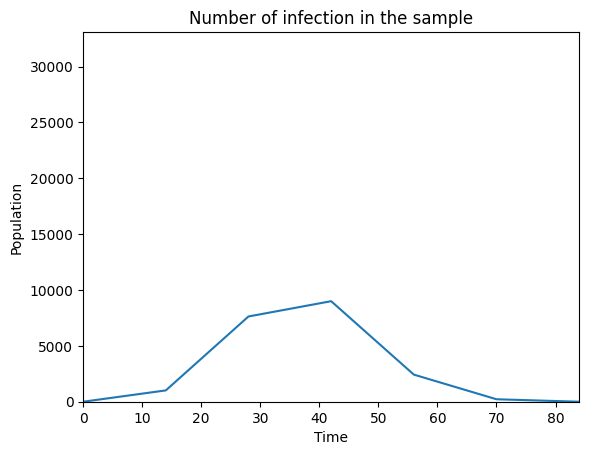

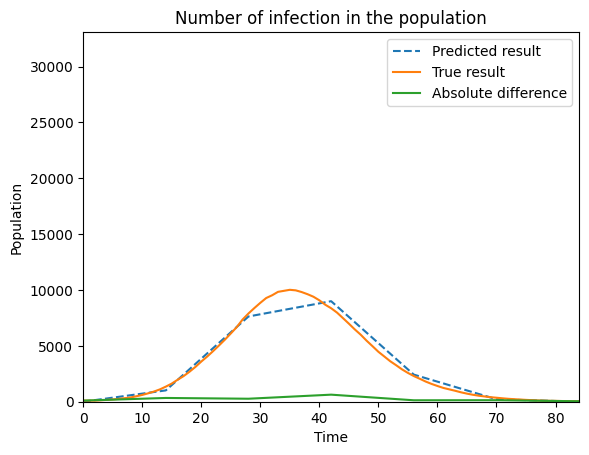

In [10]:
# Generate samples using EpiOS

# Define the class instance
postprocess = epios.PostProcess(time_data=time_data, demo_data=demo_data)
time_sample=[0, 14, 28, 42, 56, 70, 84]

# Do prediction and comparison based age-region stratification
result, diff = postprocess.predict.Base(sample_size=750,
                                        time_sample=time_sample,
                                        comparison=True,
                                        #  non_responder=False,
                                        gen_plot=True,
                                        sample_strategy='Random')

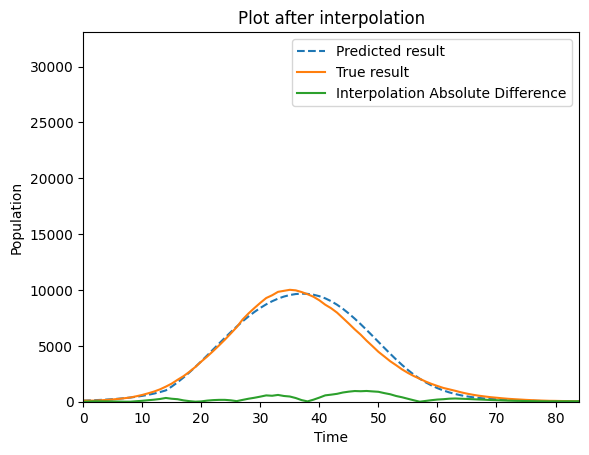

B-Spline Absolute Difference is 22059.85796354834
B-Spline Absolute Max is 962.128879120879


In [14]:
# Use B-Spline interpolation
true_result_plot = []
for t in range(max(time_sample) + 1):
    num = time_data.iloc[t, 1:].value_counts().get(3, 0)
    num += time_data.iloc[t, 1:].value_counts().get(4, 0)
    num += time_data.iloc[t, 1:].value_counts().get(5, 0)
    num += time_data.iloc[t, 1:].value_counts().get(6, 0)
    num += time_data.iloc[t, 1:].value_counts().get(7, 0)
    num += time_data.iloc[t, 1:].value_counts().get(8, 0)
    true_result_plot.append(num)
k = 3 # Degree of the spline
spline = make_interp_spline(time_sample, np.array(result[1]) * len(demo_data), k=k, bc_type='natural')  # Natural boundary conditions
y_interpolated = spline(range(max(time_sample) + 1))
x1 = time_sample[0]
x2 = time_sample[1]
y1 = true_result_plot[0]
y2 = result[1][1] * len(demo_data)
c = (np.log(y2) - np.log(y1)) / (x2 - x1)
A = y1 * np.exp(c * x1)
def exp_interpolation(x, A, c):
    return A * np.exp(c * x)
y_interpolated[0:time_sample[1]] = exp_interpolation(range(time_sample[1]), A, c)
diff_interp = np.abs(np.array(true_result_plot) - y_interpolated)
plt.figure()
plt.plot(range(max(time_sample) + 1), y_interpolated, label='Predicted result', linestyle='--')
plt.plot(range(max(time_sample) + 1), true_result_plot, label='True result')
plt.plot(range(max(time_sample) + 1), diff_interp, label='Interpolation Absolute Difference')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.xlim(0, max(time_sample))
plt.ylim(0, len(demo_data))
plt.title('Plot after interpolation')
plt.show()
score_bspline_14days = np.sum(diff_interp)
max_bspline_14days = max(diff_interp)
print('B-Spline Absolute Difference is', score_bspline_14days)
print('B-Spline Absolute Max is', max_bspline_14days)

Remarks for this interpolation result:

1. In this B-Spline implementation, I manually modify the very first interpolation interval into exponential interpolation (calculate a exponential function that passes through the first two points). The reason is to avoid negative values at the very beginning of interpolation. Furthermore, the growth is almost exponential at the beginning of this epidimeological growth.

2. More adjustments like the first point should be made in order to make this interpolation much more reasonable. `This could be the future work.`

Based on this interpolation result, we want to predict the $R_t$ values. However, using `branchpro` to predict $R_t$ requires the incidences on each day rather than prevalence (total number of infection). Therefore, we develop a package named `EpiPI` to predict the incidecnes. Running the `EpiPI` part firstly will help you to define the variables in the following block. Assume we get the predicted incidecnes, we can use `branchpro` to estimate the $R_t$ given a serial interval. 

In [28]:
# Use incidence data to predict R_t value

# Define variables needed for calculating R_t
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

ws_mean = 4
ws_var = 3**2
theta_num = ws_var / ws_mean
k = ws_mean / theta_num
w_dist = scipy.stats.gamma(k, scale=theta_num)
disc_w = w_dist.pdf(range(len(theta)))
serial_interval = disc_w

# Plot comparison between the true and predicted R_t
# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(len(theta)),
        'Incidence Number': pre_I
    }
)

inference = branchpro.BranchProPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

# Transform our true incidence data into pandas dataframes
inc_data_true = pd.DataFrame(
    {
        'Time': np.arange(len(theta)),
        'Incidence Number': incidences_true[:len(theta)]
    }
)

inference_true = branchpro.BranchProPosterior(
    inc_data=inc_data_true,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference_true.run_inference(tau=tau)
intervals_true = inference_true.get_intervals(central_prob=.95)

fig = ReproductionNumberPlot()

fig.add_interval_true_rt(intervals_true)  # Here I used a modified version of branchpro method to plot the true R_t
fig.add_interval_rt(intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/yunliqi/mambaforge/envs/limited-resources/lib/python3.11/site-packages/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



Remark for this $R_t$ plot:

1. The prior distribution are not properly set, since I have not read paper about how to set these values for COVID. Here I just put some random numbers here to see the performance of predicting $R_t$. `This is necessary to be completed.`

#### Imperfect Testing:

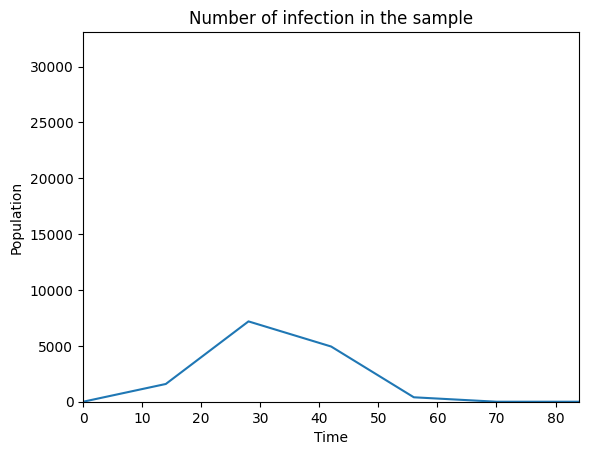

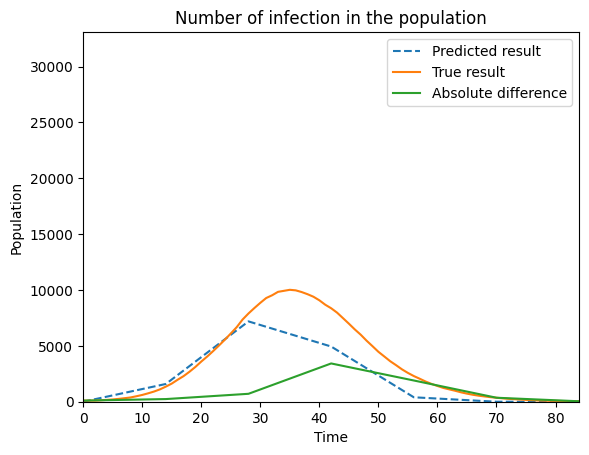

In [7]:
# Generate samples using EpiOS

# Define the class instance
practical = epios.PracticalSampler(time_data=time_data, demo_data=demo_data, positivity_curve=omega)
time_sample=[0, 14, 28, 42, 56, 70, 84]

# Do prediction and comparison based age-region stratification
result, diff = practical.predict_base(sample_size=750,
                                      time_sample=time_sample,
                                      comparison=True,
                                      #  non_responder=False,
                                      gen_plot=True,
                                      sample_strategy='Random',
                                      seed=10)

In [ ]:
# Use B-Spline interpolation
true_result_plot = []
for t in range(max(time_sample) + 1):
    num = time_data.iloc[t, 1:].value_counts().get(3, 0)
    num += time_data.iloc[t, 1:].value_counts().get(4, 0)
    num += time_data.iloc[t, 1:].value_counts().get(5, 0)
    num += time_data.iloc[t, 1:].value_counts().get(6, 0)
    num += time_data.iloc[t, 1:].value_counts().get(7, 0)
    num += time_data.iloc[t, 1:].value_counts().get(8, 0)
    true_result_plot.append(num)
k = 3 # Degree of the spline
spline = make_interp_spline(time_sample, np.array(result[1]) * len(demo_data), k=k, bc_type='natural')  # Natural boundary conditions
y_interpolated = spline(range(max(time_sample) + 1))
x1 = time_sample[0]
x2 = time_sample[1]
y1 = true_result_plot[0]
y2 = result[1][1] * len(demo_data)
c = (np.log(y2) - np.log(y1)) / (x2 - x1)
A = y1 * np.exp(c * x1)
def exp_interpolation(x, A, c):
    return A * np.exp(c * x)
y_interpolated[0:time_sample[1]] = exp_interpolation(range(time_sample[1]), A, c)
diff_interp = np.abs(np.array(true_result_plot) - y_interpolated)
plt.figure()
plt.plot(range(max(time_sample) + 1), y_interpolated, label='Predicted result', linestyle='--')
plt.plot(range(max(time_sample) + 1), true_result_plot, label='True result')
plt.plot(range(max(time_sample) + 1), diff_interp, label='Interpolation Absolute Difference')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Population')
plt.xlim(0, max(time_sample))
plt.ylim(0, len(demo_data))
plt.title('Plot after interpolation')
plt.show()
score_bspline_14days = np.sum(diff_interp)
max_bspline_14days = max(diff_interp)
print('B-Spline Absolute Difference is', score_bspline_14days)
print('B-Spline Absolute Max is', max_bspline_14days)

In [ ]:
# Use incidence data to predict R_t value

# Define variables needed for calculating R_t
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

ws_mean = 4
ws_var = 3**2
theta_num = ws_var / ws_mean
k = ws_mean / theta_num
w_dist = scipy.stats.gamma(k, scale=theta_num)
disc_w = w_dist.pdf(range(len(theta)))
serial_interval = disc_w

# Plot comparison between the true and predicted R_t
# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(len(theta)),
        'Incidence Number': pre_I
    }
)

inference = branchpro.BranchProPosterior(
    inc_data=inc_data,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

# Transform our true incidence data into pandas dataframes
inc_data_true = pd.DataFrame(
    {
        'Time': np.arange(len(theta)),
        'Incidence Number': incidences_true[:len(theta)]
    }
)

inference_true = branchpro.BranchProPosterior(
    inc_data=inc_data_true,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference_true.run_inference(tau=tau)
intervals_true = inference_true.get_intervals(central_prob=.95)

fig = ReproductionNumberPlot()

fig.add_interval_true_rt(intervals_true)  # Here I used a modified version of branchpro method to plot the true R_t
fig.add_interval_rt(intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

### Aim 2: Develop a computational tools for predicting incidences based on prevalence, which is this package - `EpiPI`

Definitions:

0. `Infected`$\coloneqq$ People that are Exposed or Infected in EpiABM. Reason: There is an incubation period for COVID.
1. $\theta_t\coloneqq$ The number of infected people at time $t$ (`Prevalence`)
2. $\omega_t\coloneqq$ The probability of a PCR positive test at $t$ days after the infection
3. $I_t\coloneqq$ The number of people that become infected at time $t$ (`Incidences`)

In [25]:
# Prepare necessary data
theta_inter = y_interpolated
theta_true = true_result_plot

In [ ]:
# Optional: Can define customised prior for the parameters
# Just need to add one more parameter `prior` when defining the IncidenceController class
prior = []
for i in range(len(theta)):
    prior.append(epipi.NormalPrior(1000, 200))
prior.append(epipi.NormalPrior(0, 1))

In order to compare the the performance of incidences prediction, firstly calculate the actual incidences each day.

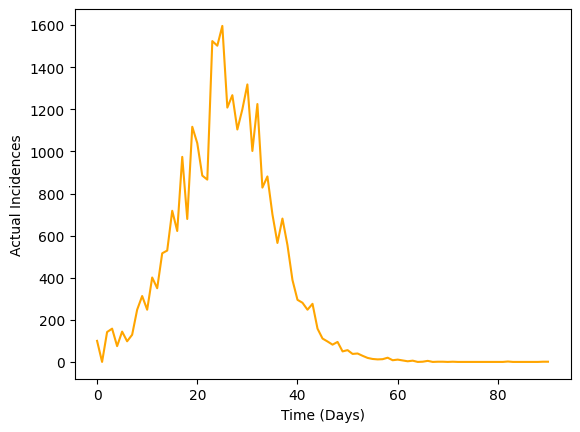

In [18]:
# Generate the incidences of the true infection data
incidences_true = []
for ind, row in time_data.iterrows():
    if ind < len(time_data) - 1:
        incidence = 0
        element_zero = []
        for i in range(1, len(row)):
            if row[i] == 1:
                element_zero.append(i)
        if len(element_zero) > 0:
            for i in element_zero:
                if time_data.iloc[ind + 1, i] > 1 and time_data.iloc[ind + 1, i] < 9:
                    incidence += 1
        incidences_true.append(incidence)
    else:
        break
incidences_true.insert(0, true_result_plot[0])
plt.figure()
plt.plot(incidences_true, color='orange')
plt.xlabel('Time (Days)')
plt.ylabel('Actual Incidences')
plt.show()

#### Model Description

According to above definition, we have defined the following model based on reference (1):
$$\theta_t\sim\text{N}\left(\sum^{\infty}_{\tau=1}\omega_{t-\tau}I_t,\;\sigma\right)$$
Here, the prevalence $\theta_t$ obeys a normal distribution with variance $\sigma$. The mean can be interpreted as the sum of infected people that are still positive on time $t$ from previous days. The variance can represent the randomness of the sampling process. Here you can see that the values of $\omega$ is very important. These values of $\omega$ is from the paper in reference (2), on the following repository: . You can also have a look at the shape of $\omega$ values below. $\omega$ values increase at first due to the existence of incubation period. And then decrease due to the immunity. 

However, this data is directly obtained in the repository, a better approach to obtain the $\omega$ values is to implement the procedures in the paper to calculate the values of $\omega$ based on the data generated from `EpiABM`. In addition, this model may not be fully compatible with `EpiABM`. The reason is that `EpiABM` does not have a direct representation of values of $\omega$.

Therefore, future work can be done here: A pipeline to take the testing result of a group of people over a period -> Generate the values of $\omega$ -> Then use these $\omega$ to predict the $R_t$ of a disease.

#### Model Implementation

In `EpiPI`, we will use `PyStan` to generate inference of $I_t$ and $\sigma$. Installation on x86 CPU are simple. However, for Apple Silicon, extra work is still needed. The best option would be a SnakeMake file to install specific versions of `httpstan (4.10.1)` and `pysimdjson (5.0.2)`. `This is necessary to complete in the future.`

The following code is to use `EpiPI` to predict incidences. Firstly, let's try performance of this model by using the actual infection data.

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (

Mean R_hat is 1.0
Std R_hat is 0.0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I[0],193.570,14.680,166.035,221.086,0.204,0.144,5510.0,2870.0,1.0
I[1],15.691,14.301,0.007,42.119,0.218,0.172,3977.0,2512.0,1.0
I[2],30.835,21.316,0.001,68.464,0.314,0.235,4110.0,2400.0,1.0
I[3],70.307,34.710,0.016,125.690,0.564,0.399,3381.0,1651.0,1.0
I[4],96.232,41.030,20.835,171.804,0.675,0.477,3489.0,2220.0,1.0
...,...,...,...,...,...,...,...,...,...
I[78],4.071,3.704,0.001,10.893,0.048,0.039,4468.0,2535.0,1.0
I[79],4.583,4.147,0.004,12.362,0.052,0.042,4203.0,2209.0,1.0
I[80],5.564,4.788,0.006,14.215,0.062,0.050,4747.0,2603.0,1.0
I[81],8.698,7.358,0.000,21.971,0.087,0.067,4763.0,2521.0,1.0


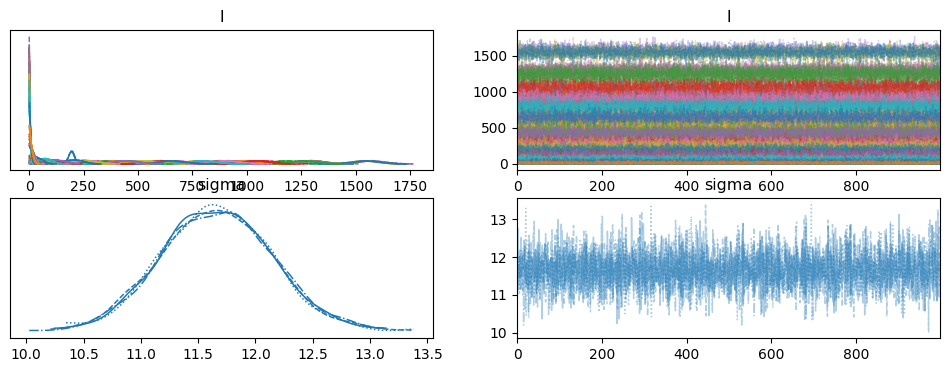

In [22]:
# Predict the R_t value using the actual infection data
theta = theta_true

# theta = theta_true
kernel = [0, 0, 0]
starting_time_point = 0
end_time_point = len(theta)
init_infection = 100
controller = epipi.InferenceController(theta[starting_time_point:end_time_point], omega, kernel=kernel)
fit, samples = controller.run()
df = az.summary(samples)
az.plot_trace(samples)
print('Mean R_hat is', df['r_hat'].values.mean())
print('Std R_hat is', df['r_hat'].values.std())
df

Here we can see that the convergence is generally good. All values are within a resonable range. $\hat{R}$ is also pretty low and stable for all parameters, which all equals to 1.0. Then let's see the comparison between the actual incidences and the estimated ones.

Remarks:

1. At the end of the inference period, since the number of $\theta$ can be used to generate inference of $I$ is fewer and fewer, the values of last few $I$s will roughly be the its initial values at the start of the iteration. To overcome this issue, I have defined `kernel` to let users to input the values of the last few $I$s. If there is no information that the user can provide, it can be left as blank. The user can discard the last few inferences manually. After experiments, these last values will not affect $I$ values predicted at smaller time points.

In [24]:
# Plot the predicted incidences
pre_I = np.array(list(df['mean'].values[:-1]) + kernel)
pre_std = np.array(list(df['sd'].values[:-1]) + kernel)

figure = go.Figure()

trace1 = go.Scatter(
    y=pre_I,
    x=list(range(starting_time_point, end_time_point)),
    mode='lines',
    name='Estimated Incidences',
    line_color='indigo'
)

trace2 = go.Scatter(
    x=list(range(starting_time_point, end_time_point)) + list(range(starting_time_point, end_time_point))[::-1],
    y=(pre_I + 1.96 * pre_std).tolist() + (pre_I - 1.96 * pre_std).tolist()[::-1],
    fill='toself',
    fillcolor='indigo',
    line_color='indigo',
    opacity=0.5,
    mode='lines',
    name='Credible interval 0.95',
)

trace3 = go.Scatter(
    y=incidences_true,
    x=list(range(starting_time_point, end_time_point)),
    mode='lines',
    name='Actual Incidences',
    line_color='green'
)

figure.add_trace(trace1)
figure.add_trace(trace2)
figure.add_trace(trace3)

Generally, we can see that the result performs very well. Therefore, we try to use the interpolated total infection below.

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 28: Argument
    1700 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/var/folders/5q/gy5_gx0s17j9qlczj9knlfwm0000gn/T/httpstan_md5574m4/model_kvyygi43.stan', line 49, column 22: Argument
    5000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   1% (101/8000)
Sampling:   1% (102/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling

Mean R_hat is 1.0
Std R_hat is 0.0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I[0],246.172,14.042,220.058,272.115,0.178,0.126,6368.0,3145.0,1.0
I[1],12.013,11.421,0.001,32.308,0.169,0.135,4020.0,2066.0,1.0
I[2],22.088,17.201,0.000,54.184,0.234,0.183,4747.0,2499.0,1.0
I[3],56.900,30.274,0.464,106.271,0.473,0.345,3749.0,2039.0,1.0
I[4],79.930,40.783,1.474,146.624,0.662,0.468,3506.0,2025.0,1.0
...,...,...,...,...,...,...,...,...,...
I[78],2.020,1.955,0.000,5.684,0.025,0.021,4322.0,2424.0,1.0
I[79],2.309,2.239,0.000,6.416,0.028,0.024,4453.0,2019.0,1.0
I[80],2.998,2.924,0.000,8.373,0.039,0.035,4494.0,2421.0,1.0
I[81],4.815,4.535,0.000,13.394,0.058,0.049,4421.0,2265.0,1.0


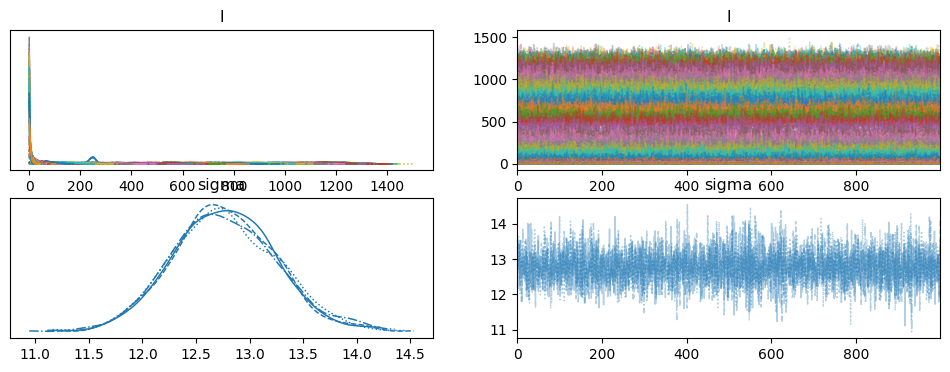

In [26]:
# Predict the R_t value using the interpolated infection data
theta = theta_inter

# theta = theta_true
kernel = [0, 0, 0]
starting_time_point = 0
end_time_point = len(theta)
init_infection = 100
controller = epipi.InferenceController(theta[starting_time_point:end_time_point], omega, kernel=kernel)
fit, samples = controller.run()
df = az.summary(samples)
az.plot_trace(samples)
print('Mean R_hat is', df['r_hat'].values.mean())
print('Std R_hat is', df['r_hat'].values.std())
df

In [27]:
# Plot the predicted incidences
pre_I = np.array(list(df['mean'].values[:-1]) + kernel)
pre_std = np.array(list(df['sd'].values[:-1]) + kernel)

figure = go.Figure()

trace1 = go.Scatter(
    y=pre_I,
    x=list(range(starting_time_point, end_time_point)),
    mode='lines',
    name='Estimated Incidences',
    line_color='indigo'
)

trace2 = go.Scatter(
    x=list(range(starting_time_point, end_time_point)) + list(range(starting_time_point, end_time_point))[::-1],
    y=(pre_I + 1.96 * pre_std).tolist() + (pre_I - 1.96 * pre_std).tolist()[::-1],
    fill='toself',
    fillcolor='indigo',
    line_color='indigo',
    opacity=0.5,
    mode='lines',
    name='Credible interval 0.95',
)

trace3 = go.Scatter(
    y=incidences_true,
    x=list(range(starting_time_point, end_time_point)),
    mode='lines',
    name='Actual Incidences',
    line_color='green'
)

figure.add_trace(trace1)
figure.add_trace(trace2)
figure.add_trace(trace3)

Generally, the interpolated data does not work much worse than the true infection data. The performance might be improved if the interpolation methods are more accurate.

### References

1. Bajaj, Sumali, et al. "Understanding COVID-19 testing behaviour in England through a sociodemographic lens." medRxiv (2023): 2023-10.
2. Hellewell, Joel, et al. "Estimating the effectiveness of routine asymptomatic PCR testing at different frequencies for the detection of SARS-CoV-2 infections." BMC medicine 19 (2021): 1-10.